# TC3006B
## Deep Learning
## Neural Networks Primer
<br>

#### Building a NN for CIFAR10 dataset with PyTorch
<br>

- Objective

    The main goal of this activity is to further your understanding of Fully Connected and Convolutional Neural Networks (CNNs) by building one using PyTorch. You will apply this architecture to the famous CIFAR10 dataset.

- Instructions

    Understand the Guide Code: Review the provided guide code. Note how PyTorch makes it easier to implement neural networks.

    The code contains importand sections that you must understand fully, take your time, and experiment!




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/TE3002B/DeepLearning')

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
#only if you have jupyterthemes
# from jupyterthemes import jtplot
# jtplot.style()

### Download Cifar10 dataset

<img src="cifar10.png">

In [ ]:
torch.cuda.is_available()

True

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/TE3002B/DeepLearning'
NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST = 5000
MINIBATCH_SIZE = 64

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Train dataset
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_cifar)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
#Validation set
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                           transform=transform_cifar)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))
#Test set
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                            transform=transform_cifar)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test))))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/drive/MyDrive/Colab Notebooks/TE3002B/DeepLearning
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

In [ ]:
train_loader.batch_size

64

In [ ]:
for i, (x, y) in enumerate(train_loader):
    print(x, y)

### Using  GPUs

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


### Mostrar imágenes

La imagen muestreada representa un: truck


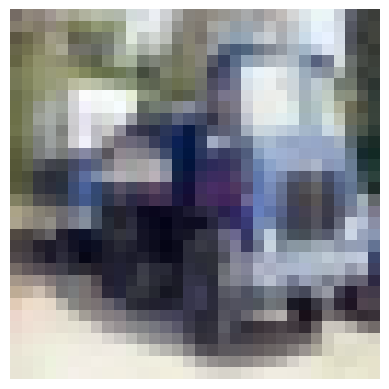

In [ ]:
classes = test_loader.dataset.classes
def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)


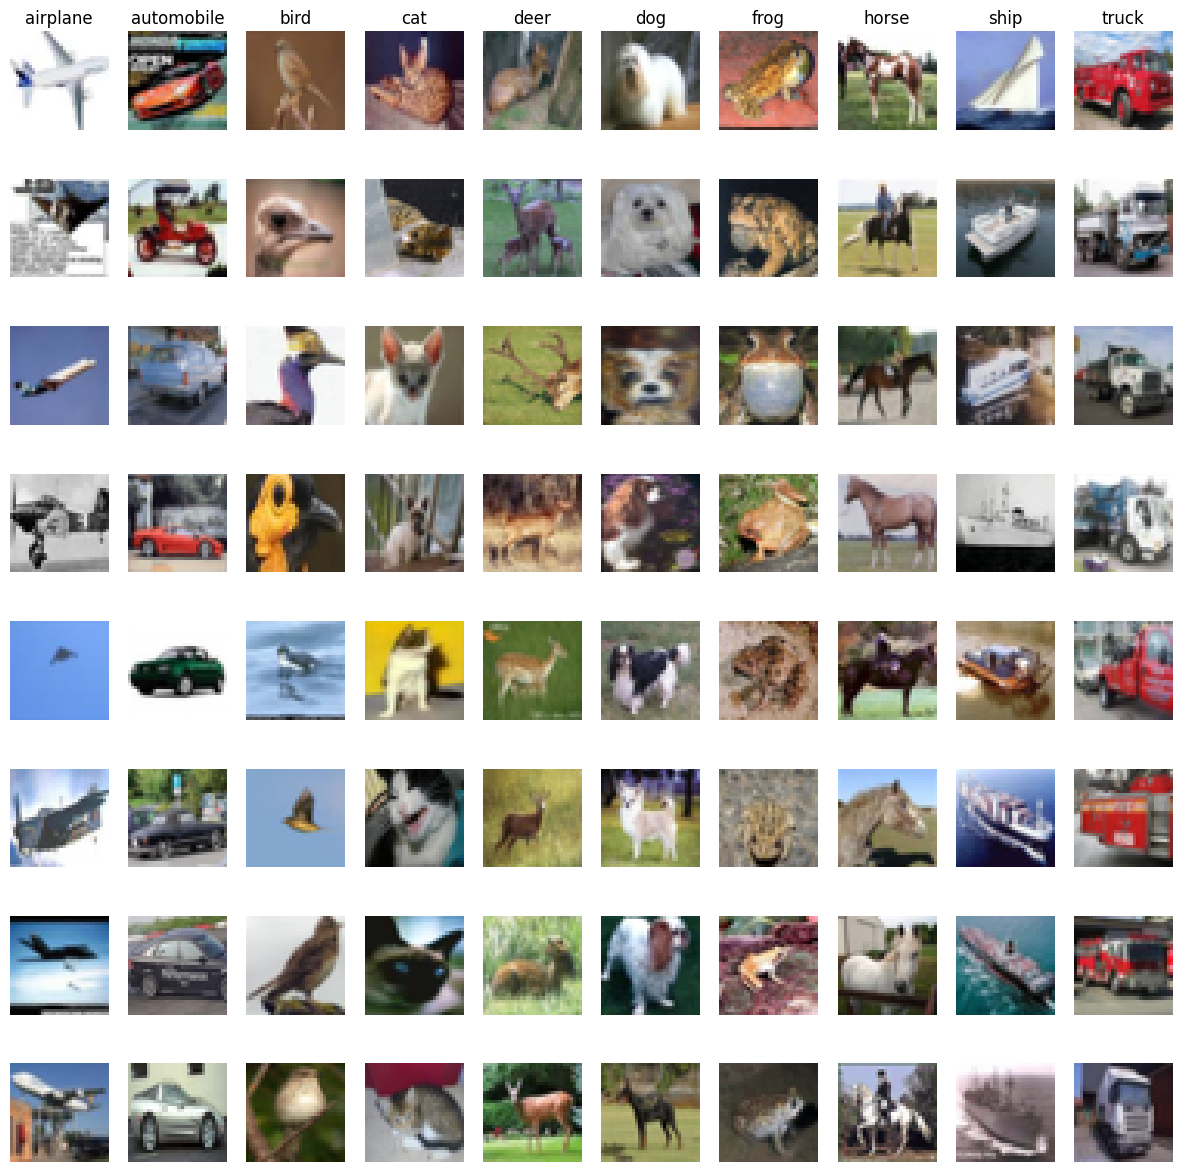

In [ ]:
def plot_cifar10_grid():
    classes = test_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')

            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid()

### Calcular accuracy


In [ ]:
for i, (x,y) in enumerate(test_loader):
    print(i, x.shape, y.shape)

In [ ]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi)
            _, pred = scores.max(dim=1)
            num_correct += (pred == yi).sum()
            num_total += pred.size(0)
        return float(num_correct)/num_total

### Loop de entrenamiento

In [ ]:
def train(model, optimiser, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            cost = F.cross_entropy(input= scores, target=yi)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
        acc = accuracy(model, val_loader)
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')

### Sequential linear

In [ ]:
hidden1 = 256
hidden = 512
lr = 0.001
epochs = 3
model1 = nn.Sequential(nn.Flatten(),
                       nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr)
# optimiser = torch.optim.RMSprop(model1.parameters(), lr=l)

In [ ]:
train(model1, optimiser, epochs)

Epoch: 0, costo: 1.6403871774673462, accuracy: 0.452,
Epoch: 1, costo: 1.388662576675415, accuracy: 0.5014,
Epoch: 2, costo: 1.4049524068832397, accuracy: 0.5096,


### Sequential CNN

In [ ]:
layer_1 = 16
layer_2 = 32
epochs = 10
num_classes = 10
lr=1e-3

modelCNN1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=layer_1,
                                    kernel_size=3, padding=1), #32x32x16
                  nn.ReLU(),
                  nn.Conv2d(in_channels=layer_1, out_channels=layer_2,
                            kernel_size=3, padding=1),#32x32x32
                  nn.ReLU(),
                  nn.MaxPool2d(2, 2), # 16x16x32
                  nn.Flatten(), # 8192, 1
                  nn.Linear(in_features= 16*16*32, out_features = num_classes))
optimiser = torch.optim.Adam(modelCNN1.parameters(), lr)

In [ ]:
train(modelCNN1, optimiser, epochs)

Epoch: 0, costo: 1.1045417785644531, accuracy: 0.6164,
Epoch: 1, costo: 1.3462705612182617, accuracy: 0.6636,
Epoch: 2, costo: 0.8741924166679382, accuracy: 0.6744,
Epoch: 3, costo: 0.9983283877372742, accuracy: 0.677,
Epoch: 4, costo: 0.46495378017425537, accuracy: 0.675,
Epoch: 5, costo: 0.6521122455596924, accuracy: 0.6594,
Epoch: 6, costo: 0.9376704692840576, accuracy: 0.6658,
Epoch: 7, costo: 0.20681661367416382, accuracy: 0.6584,
Epoch: 8, costo: 0.33938148617744446, accuracy: 0.662,
Epoch: 9, costo: 0.5899776816368103, accuracy: 0.6532,


### OOP

In [ ]:
class CNN_class1(nn.Module):
    def __init__(self, layer_1, layer_2, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=layer_1,
                               kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=layer_1, out_channels=layer_2,
                               kernel_size=3, padding=1)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=16*16*layer_2, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.conv2(F.relu(self.conv1(x))))
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.linear(x)

In [ ]:
layer_1 = 16
layer_2 = 32
epochs = 10
num_classes = 10
lr=1e-4
modelCNN2 = CNN_class1(layer_1, layer_2, num_classes)
optimiser = torch.optim.Adam(modelCNN2.parameters(), lr)

In [ ]:
train(modelCNN2, optimiser, epochs)

Epoch: 0, costo: 1.9768710136413574, accuracy: 0.489,
Epoch: 1, costo: 1.383563756942749, accuracy: 0.546,
Epoch: 2, costo: 1.2169861793518066, accuracy: 0.5654,
Epoch: 3, costo: 1.964864730834961, accuracy: 0.5772,
Epoch: 4, costo: 0.8138983845710754, accuracy: 0.5922,
Epoch: 5, costo: 1.4049845933914185, accuracy: 0.6002,
Epoch: 6, costo: 1.068569540977478, accuracy: 0.6108,
Epoch: 7, costo: 1.0575107336044312, accuracy: 0.627,
Epoch: 8, costo: 0.7173815369606018, accuracy: 0.6366,
Epoch: 9, costo: 1.5325511693954468, accuracy: 0.644,


### Un poco más elegante

In [ ]:
conv_k_3 = lambda channel1, channel2: nn.Conv2d(channel1, channel2, kernel_size=3, padding=1)

In [ ]:
class CNN_class2(nn.Module):
    def __init__(self, in_channel, channel1, channel2, num_classes):
        super().__init__()
        self.conv1 = conv_k_3(in_channel, channel1)
        self.conv2 = conv_k_3(channel1, channel2)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=16*16*channel2,
                                out_features=num_classes)
    def forward(self, x):
        x = F.relu(self.conv2(F.relu(self.conv1(x))))
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.linear(x)

In [ ]:
layer_1 = 16
layer_2 = 32
epochs = 3
num_classes = 10
lr=1e-3
modelCNN3 = CNN_class2(3, layer_1, layer_2, num_classes)
optimiser = torch.optim.Adam(modelCNN3.parameters(), lr)

In [ ]:
train(modelCNN3, optimiser, epochs)

Epoch: 0, costo: 1.4547340869903564, accuracy: 0.6388,
Epoch: 1, costo: 0.6866675019264221, accuracy: 0.6616,
Epoch: 2, costo: 0.8396422863006592, accuracy: 0.678,


### Batch Normalization

In [ ]:
class CNN_BN(nn.Module):
    def __init__(self, in_channel, channel1,
                 channel2, num_classes):
        super().__init__()
        self.conv1 = conv_k_3(in_channel, channel1)
        self.bn1 = nn.BatchNorm2d(channel1)

        self.conv2 = conv_k_3(channel1, channel2)
        self.bn2 = nn.BatchNorm2d(channel2)

        self.max_pool = nn.MaxPool2d(2, 2)
        self.linear = nn.Linear(in_features=16*16*channel2,
                               out_features=num_classes)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.linear(x)


In [ ]:
layer_1 = 16
layer_2 = 32
epochs = 10
num_classes = 10
lr=1e-3
model_BN = CNN_BN(3, layer_1, layer_2, num_classes)
optimiser = torch.optim.Adam(model_BN.parameters(), lr)

In [ ]:
train(model_BN, optimiser, epochs)

Epoch: 0, costo: 1.7146481275558472, accuracy: 0.6154,
Epoch: 1, costo: 1.4605684280395508, accuracy: 0.6418,
Epoch: 2, costo: 0.6162745356559753, accuracy: 0.6558,
Epoch: 3, costo: 1.1367151737213135, accuracy: 0.6606,
Epoch: 4, costo: 0.6268239617347717, accuracy: 0.6622,
Epoch: 5, costo: 0.49619773030281067, accuracy: 0.6822,
Epoch: 6, costo: 0.509575366973877, accuracy: 0.6704,
Epoch: 7, costo: 0.6659384965896606, accuracy: 0.6794,
Epoch: 8, costo: 0.5661763548851013, accuracy: 0.6882,
Epoch: 9, costo: 0.4965863525867462, accuracy: 0.6716,
